In [1]:
import glob
from collections import defaultdict
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from pymutspec.annotation import CodonAnnotation, mutations_summary

from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error
from Bio import SeqIO

import warnings
warnings.filterwarnings("ignore")

from utils import prepare_exp_aa_subst, prepare_aa_subst, get_equilibrium_freqs, calc_metrics, amino_acid_codes

In [2]:
coda = CodonAnnotation(2)

## Analyse vertebrates

In [4]:
ms12 = pd.read_csv('../192/1data_derivation/dataset/MutSpecVertebrates12.csv.gz')
ms12

,Gene,Class,Species,Mut,Observed,Expected,MutSpec
0,CO1,Mammalia,Crocuta_crocuta,A>C,NaN,115.066667,0.000000
1,CO1,Mammalia,Crocuta_crocuta,A>G,11.500444,173.333333,0.162818
2,CO1,Mammalia,Crocuta_crocuta,A>T,NaN,115.066667,0.000000
3,CO1,Mammalia,Crocuta_crocuta,C>A,NaN,71.466667,0.000000
4,CO1,Mammalia,Crocuta_crocuta,C>G,NaN,71.466667,0.000000
...,...,...,...,...,...,...,...
34387,CO3,Actinopteri,Cottus_gulosus,G>C,NaN,7.166667,0.000000
34388,CO3,Actinopteri,Cottus_gulosus,G>T,NaN,7.166667,0.000000
34389,CO3,Actinopteri,Cottus_gulosus,T>A,0.600700,32.500000,0.029888
34390,CO3,Actinopteri,Cottus_gulosus,T>C,1.384498,64.916667,0.034487


In [20]:
cls_spectra = {}
cls_eqs = {}
for _cls, df_cls in ms12.groupby('Class'):
    cls_spectra[_cls] = df_cls.query('Gene == "Cytb"').groupby('Mut').MutSpec.mean().reset_index()
    _, aa_eq = get_equilibrium_freqs(cls_spectra[_cls], gc=2)
    cls_eqs[_cls] = aa_eq.set_index('aa').eq_freq.rename(_cls)

cls_spectra['Mammalia']

,Mut,MutSpec
0,A>C,0.006995
1,A>G,0.067613
2,A>T,0.012740
3,C>A,0.024510
4,C>G,0.005048
5,C>T,0.124436
6,G>A,0.480826
7,G>C,0.021098
8,G>T,0.019011
9,T>A,0.014834


<Axes: xlabel='aa'>

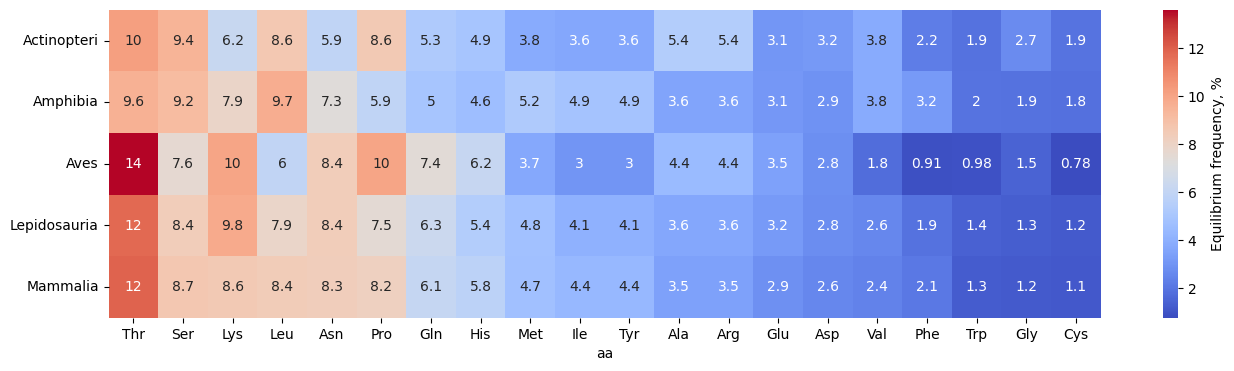

In [32]:
_ = pd.DataFrame(cls_eqs).sort_values('Mammalia', ascending=False) * 100

plt.figure(figsize=(16, 4))
sns.heatmap(_.T, annot=True, cmap='coolwarm', cbar_kws={'label': 'Equilibrium frequency, %'})

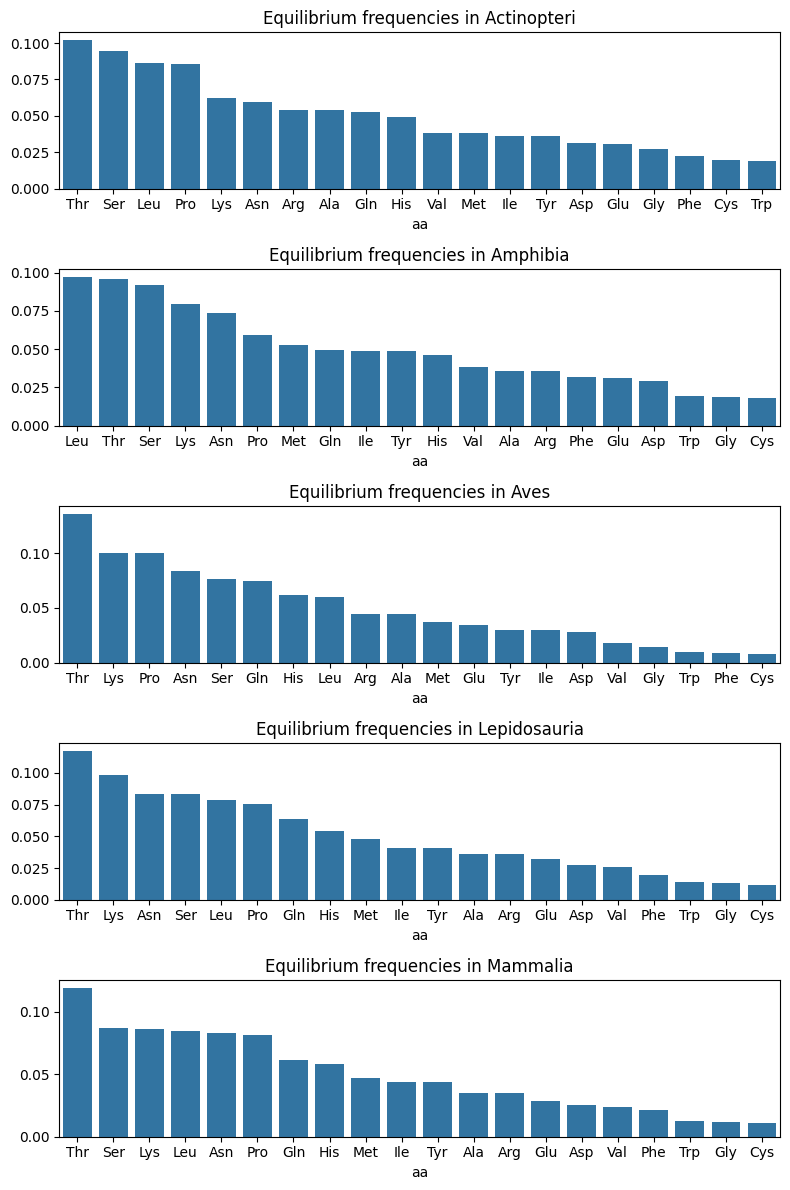

In [45]:
plt.figure(figsize=(8, 12))
for i, _cls in enumerate(cls_eqs):
    plt.subplot(5, 1, i + 1)
    plt.title(f'Equilibrium frequencies in {_cls}')
    sns.barplot(x=cls_eqs[_cls].index, y=cls_eqs[_cls].values)
plt.tight_layout()

In [92]:
obs_df_ns_flt = pd.read_csv('./vertebrates_aa_subst/dataset/obs_muts.csv')
obs_df_ns_flt

,Mut,MutType,Site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,RefNode,AltNode,species,gene,class,edge_nobs,species_nobs
0,A[A>G]T,0,112,1,ATT,GTT,I,V,0.958489,0.849141,Node5,Node6,Macaca_mulatta,ND6,Mammalia,1.70197,60.8728
1,T[G>A]T,0,127,1,GTT,ATT,V,I,0.974793,0.970650,Node6,Node12,Macaca_mulatta,ND6,Mammalia,4.31735,60.8728
2,G[A>G]T,0,301,1,ATA,GTA,M,V,0.999990,0.999990,Node24,RN_6,Macaca_mulatta,ND6,Mammalia,0.99999,60.8728
3,T[G>A]T,0,109,1,GTA,ATA,V,M,0.999990,0.999990,Node22,RN_32,Macaca_mulatta,ND6,Mammalia,0.99999,60.8728
4,A[A>G]T,0,97,1,ATT,GTT,I,V,1.000000,1.000000,Node25,RN_5,Macaca_mulatta,ND6,Mammalia,1.00000,60.8728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71036,G[T>C]T,0,320,2,GTT,GCT,V,A,0.997300,0.996791,Node7,Node15,Microtus_richardsoni,CO3,Mammalia,2.99087,37.8538
71037,A[G>A]C,0,470,2,AGC,AAC,S,N,0.976132,0.976132,Node8,Node14,Microtus_richardsoni,CO3,Mammalia,5.21561,37.8538
71038,A[C>T]T,0,139,1,CTT,TTT,L,F,0.980432,0.980432,Node9,RN_10,Microtus_richardsoni,CO3,Mammalia,5.85689,37.8538
71039,A[A>G]T,0,574,1,ATC,GTC,I,V,0.960485,0.960485,Node9,RN_10,Microtus_richardsoni,CO3,Mammalia,5.85689,37.8538


In [132]:
# derive aa content from fasta file
from collections import Counter
path_to_fasta = '../192/1data_derivation/nemu_input/Cytb.fasta'
aa_content = {_cls: [] for _cls in cls_spectra}
nerr = 0
for rec in SeqIO.parse(path_to_fasta, 'fasta'):
    cur_aa_content = Counter(rec.seq)
    _cls = rec.description.split('###Chordata_7711;')[1].split('_')[0]
    if _cls not in aa_content:
        nerr += 1
        continue
    aa_content[_cls].append(cur_aa_content)

aa_content_mean = {}
for _cls in aa_content:
    aa_content_mean[_cls] = pd.DataFrame(aa_content[_cls]).rename(columns=amino_acid_codes)\
        .fillna(0).mean().to_dict()
    for x in ['X', 'B', 'Z', 'J']:
        if x in aa_content_mean[_cls]:
            del aa_content_mean[_cls][x]

nerr

154

In [137]:
for _cls in aa_content_mean:
    obs_aa_mut = obs_df_ns_flt.query('gene == "Cytb" & `class` == @_cls')\
        .rename(columns={'ProbaMut': 'count', 'RefAa': 'aa1', 'AltAa': 'aa2'})
    exp_aa_subst = prepare_exp_aa_subst(cls_spectra[_cls], 'MutSpec', 2)[0]
    aa_subst = prepare_aa_subst(obs_aa_mut, exp_aa_subst, aa_content_mean[_cls])
    metr = calc_metrics(aa_subst)
    metr['class'] = _cls
    print(_cls, metr['pearson_corr']**2, metr['r2'])

Actinopteri 0.35107961069009536 0.1487047968887264
Amphibia 0.3363370840905314 0.2938798263324567
Aves 0.3686969616775849 0.2761764860846042
Lepidosauria 0.3813790009125735 0.25039007309272354
Mammalia 0.4051658221744695 0.3549100833973525


In [138]:
metr

{'r2': 0.3549100833973525,
 'mape': 1.4633380598001273,
 'wape': 0.8174694287430023,
 'slope': np.float64(0.5478609787867941),
 'intercept': np.float64(0.0032295644372371843),
 'spearman_corr': np.float64(0.5392826504362745),
 'spearman_p': np.float64(6.2242279720592235e-12),
 'pearson_corr': np.float64(0.6365263719395053),
 'pearson_p': np.float64(2.859387657538147e-17),
 'ks_stat': np.float64(0.2),
 'ks_p': np.float64(0.007266829072827465),
 'rmse': 0.010697204045374172,
 'log_likelihood': np.float64(-5.6198974591614235),
 'mut_count': np.float64(14038.639030999997),
 'mut_type_count': np.int64(140),
 'class': 'Mammalia'}

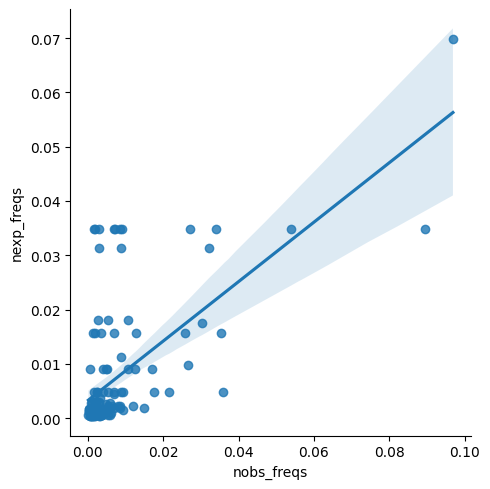

In [141]:
sns.lmplot(aa_subst, x='nobs_freqs', y='nexp_freqs')
# plt.xscale('log')
# plt.yscale('log')
plt.show()